In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [3]:
# Section 2 Project
# PUBG 상위 10% 유저들에 대한 분석

# 라이브러리 호출
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

# warning 무시
warnings.filterwarnings('ignore')

sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False},
        style='whitegrid')

plt.rc('font', family='NanumBarunGothic') 

In [4]:
# 데이터셋 불러오기

df = pd.read_csv('/content/drive/MyDrive/train_V2.csv')
print('rows: {}, columns : {}' .format(df.shape[0], df.shape[1]))

rows: 4446966, columns : 29


In [5]:
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [6]:
# id 데이터에서 불필요한 문자열 삭제
df['Id'] = df['Id'].str.replace(r'[a-zA-Z]', "")
df['groupId'] = df['groupId'].str.replace(r'[a-zA-Z]', "")
df['matchId'] = df['matchId'].str.replace(r'[a-zA-Z]', "")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

### 1. EDA

1. 데이터셋 설명




groupId - 플레이어 팀의 ID

matchId - 대전 ID

assists - 어시스트 킬 수

boosts - 플레이어가 사용한 에너지 소모품의 수(에너지 드링크, 진통제 등)

damageDealt - 적에게 입힌 데미지

DBNOs - HP가 0이지만 죽지 않은 경우

headshotKills - 헤드샷으로 사망한 적의 수

heals - 플레이어가 사용한 치유 아이템의 수(붕대, 구급상자 등)

killPlace - 킬을 기반으로 한 경기의 순위

killPoints - 킬 포인트를 기반으로 한 경기의 순위

kills - 사망한 적 플레이어의 수

killStreaks - 짧은 시간안에 죽인 적 플레이어의 최대 수

longestKill - 플레이어와 사망한 적 사이의 가장 긴 거리

matchDuration - 시간 단위(마하)

matchType - 대전 유형(솔로, 듀오, 스쿼드)

maxPlace - 게임 내 가장 최악의 장소

numGroups - 게임 내 팀의 숫자

revives - 플레이어가 팀원을 소생시킨 횟수

rideDistance - 차량의 이동 거리

roadKills - 이동 수단으로 킬한 횟수

swimDistance - 수영으로 이동한 거리

teamKills - 아군 사격으로 인한 팀킬 횟수

vehicleDestroys - 파괴된 차량의 수

walkDistance - 도보로 이동한 거리

weaponsAcquired - 획득한 무기의 수

winPoints - 승리한 경기를 기준으로 한 경기 순위

타겟 컬럼:

winPlacePerc - 정규화된 순위 데이터(숫자가 1이면 1위, 0에 가까울 수록 하위 순위(소숫점 4자리))


In [8]:
# 매우 다양한 요소들이 게임의 승패를 좌우하기 때문에 컬럼은 드랍하지 않는 선에서 데이터 정제
df.describe

<bound method NDFrame.describe of                   Id       groupId       matchId  assists  boosts  \
0         7962878858      44580459     103571491        0       0   
1           90569903   68456564429      37557110        0       0   
2            1907372    6442324574     110163894        1       0   
3        46163652853     930979721       1144127        0       0   
4           31596269     040103458      68871216        0       0   
...              ...           ...           ...      ...     ...   
4446961       765210     238426507  184928345635        0       0   
4446962    419737460       4085462    8548373769        0       1   
4446963   1948129588         26847      60127841        0       0   
4446964       032737  222335411394      97010758        0       4   
4446965      0877286        874725       6216095        0       2   

         damageDealt  DBNOs  headshotKills  heals  killPlace  ...  revives  \
0               0.00      0              0      0         6

In [9]:
# 누락된 데이터가 있는지 확인
na_data = df.isna().sum().to_frame()
na_data.columns = ['NA data']

na_data

,NA data
Id,0
groupId,0
matchId,0
assists,0
boosts,0
damageDealt,0
DBNOs,0
headshotKills,0
heals,0
killPlace,0


In [10]:
# 누락된 데이터 제거
df[df['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,7074418064,123392,22412353008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [11]:
df.drop(2744604, inplace=True)

In [12]:
# 매칭데이터의 갯수확인
matches = df.loc[:,"matchId"].nunique()
print("{} 개의 매칭데이터가 등록되어있습니다.".format(matches))

47928 개의 매칭데이터가 등록되어있습니다.


In [13]:
# 매치타입별 플레이 횟수 확인
# FPP - 1인칭 시점
# TPP - 3인칭 시점
# NORMAL - 게임중에 전환가능한 시점

match_types = df.loc[:,"matchType"].value_counts().to_frame().reset_index()
match_types.columns = ["Type","Count"]
match_types

,Type,Count
0,squad-fpp,1756186
1,duo-fpp,996691
2,squad,626526
3,solo-fpp,536761
4,duo,313591
5,solo,181943
6,normal-squad-fpp,17174
7,crashfpp,6287
8,normal-duo-fpp,5489
9,flaretpp,2505


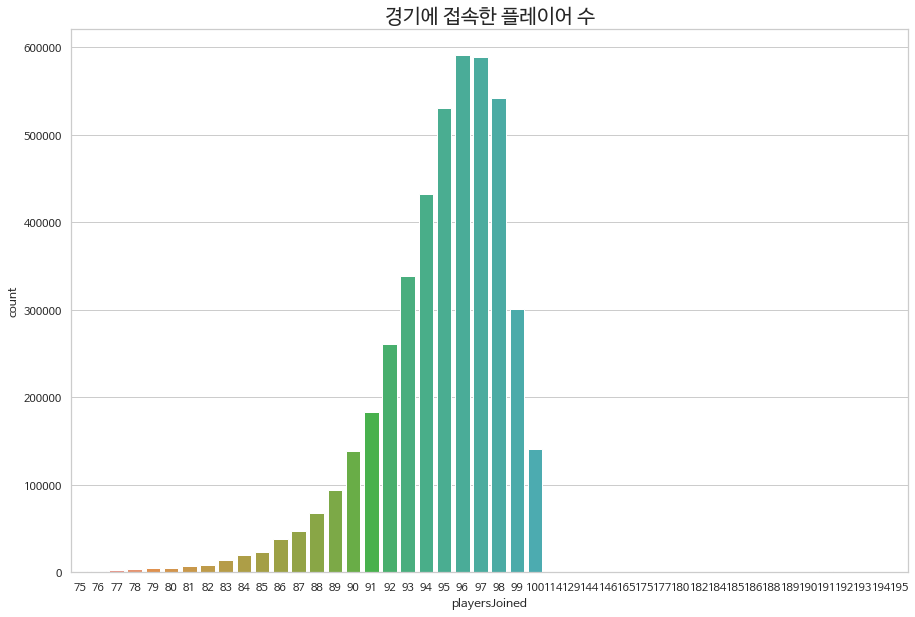

In [14]:
# 접속한 유저 데이터
df['playersJoined'] = df.groupby('matchId')['matchId'].transform('count')
plt.figure(figsize=(15,10))
sns.countplot(df[df['playersJoined']>=75]['playersJoined'])
plt.title('경기에 접속한 플레이어 수', fontsize=20)
plt.show()

In [15]:
# 킬, 딜량, 경기 내 최악의 장소, 시간단위 데이터를 정규화(Normalization)
df['killsNorm'] = df['kills']*((100-df['playersJoined'])/100 + 1)
df['damageDealtNorm'] = df['damageDealt']*((100-df['playersJoined'])/100 + 1)
df['maxPlaceNorm'] = df['maxPlace']*((100-df['playersJoined'])/100 + 1)
df['matchDurationNorm'] = df['matchDuration']*((100-df['playersJoined'])/100 + 1)

to_show = ['Id', 'kills','killsNorm','damageDealt', 'damageDealtNorm', 'maxPlace', 'maxPlaceNorm', 'matchDuration', 'matchDurationNorm']
df[to_show][0:11]

,Id,kills,killsNorm,damageDealt,damageDealtNorm,maxPlace,maxPlaceNorm,matchDuration,matchDurationNorm
0,7962878858,0,0.00,0.000,0.00000,28,29.12,1306,1358.24
1,90569903,0,0.00,91.470,99.70230,26,28.34,1777,1936.93
2,1907372,0,0.00,68.000,69.36000,50,51.00,1318,1344.36
3,46163652853,0,0.00,32.900,35.86100,31,33.79,1436,1565.24
4,31596269,1,1.03,100.000,103.00000,97,99.91,1424,1466.72
5,7912326506,1,1.05,100.000,105.00000,28,29.40,1395,1464.75
6,959590213,0,0.00,0.000,0.00000,28,28.84,1316,1355.48
7,3118464390,0,0.00,8.538,8.87952,96,99.84,1967,2045.68
8,1682049891,0,0.00,51.600,53.14800,28,28.84,1375,1416.25
9,5543587253,0,0.00,37.270,38.38810,29,29.87,1930,1987.90


In [16]:
# 치유(Heal)와 에너지(Boost)를 합한 데이터 컬럼 추가
# 랜덤 포레스트에 활용 예정

df['healsandboosts'] = df['heals'] + df['boosts']
df[['heals', 'boosts', 'healsandboosts']].tail()

,heals,boosts,healsandboosts
4446961,0,0,0
4446962,0,1,1
4446963,0,0,0
4446964,2,4,6
4446965,1,2,3


In [17]:
# 움직이지 않고 킬을 당하는 부정행위를 하는 유저가 있는지 확인하기 위해 총 이동거리수(totalDistance) 데이터컬럼 추가
df['totalDistance'] = df['rideDistance'] + df['walkDistance'] + df['swimDistance'] # 총 이동거리 = 차량탑승 + 도보 + 수영
df['killsWithoutMoving'] = ((df['kills'] > 0) & (df['totalDistance'] == 0)) # 움직이지 않고 킬 발생(부정행위 의심)

In [18]:
# 부정행위 판별 2
# 헤드샷 지수 확인 컬럼 추가(headshotRate)
df['headshot_rate'] = df['headshotKills'] / df['kills']
df['headshot_rate'] = df['headshot_rate'].fillna(0)

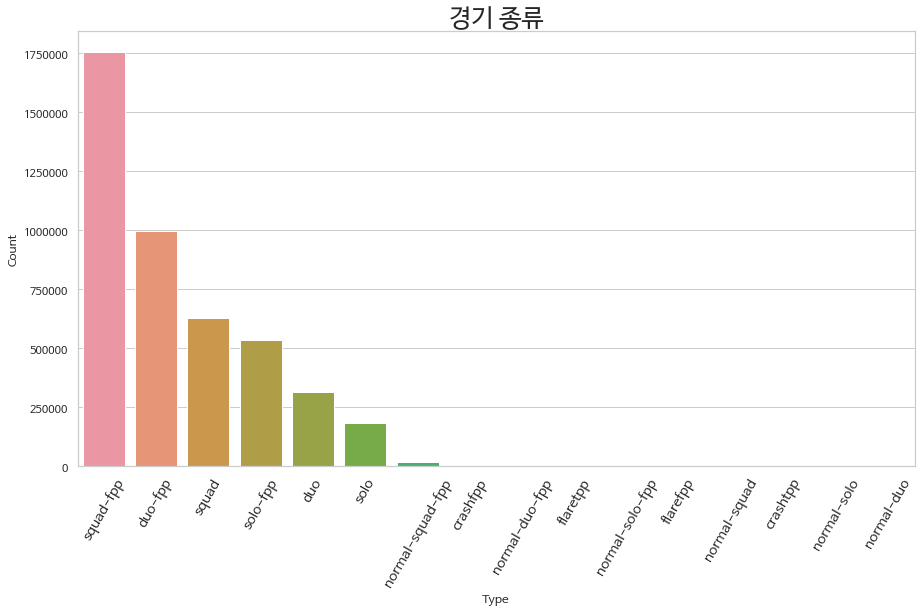

In [19]:
# 매치 타입
# 1인칭 스쿼드가 가장 많이 플레이됨을 알 수 있다.
plt.figure(figsize=(15,8))
ticks = match_types.Type.values
ax = sns.barplot(x="Type", y="Count", data=match_types)
ax.set_xticklabels(ticks, rotation=60, fontsize=14)
ax.set_title("경기 종류", fontsize=25)
plt.show()

In [20]:
# 각 매치타입별로 합치기
match_types2 = df.loc[:,"matchType"].value_counts().to_frame()
squad = match_types2.loc[["squad-fpp","squad","normal-squad-fpp","normal-squad"],"matchType"].sum()
duo = match_types2.loc[["duo-fpp","duo","normal-duo-fpp","normal-duo"],"matchType"].sum()
solo = match_types2.loc[["solo-fpp","solo","normal-solo-fpp","normal-solo"],"matchType"].sum()
match_types_mount = pd.DataFrame([squad,duo,solo], index=["squad","duo","solo"], columns =["count"])
match_types_mount

,count
squad,2400402
duo,1315970
solo,720712


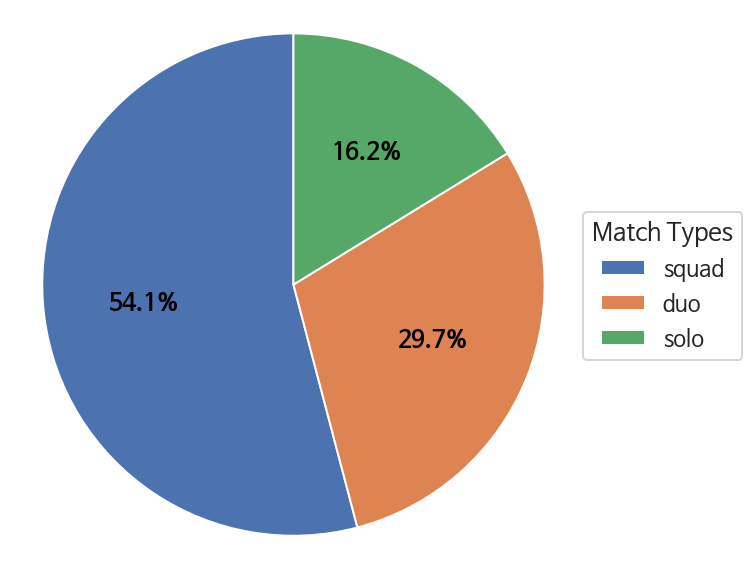

In [21]:
# 시각화

import matplotlib as mpl
plt.rc('font', family='NanumBarunGothic') 
mpl.rc('axes', unicode_minus=False)

from IPython.display import set_matplotlib_formats

set_matplotlib_formats("retina")

fig1, ax1 = plt.subplots(figsize=(5, 5))
labels = ['squad', 'duo', 'solo']

wedges, texts, autotexts = ax1.pie(match_types_mount["count"],textprops=dict(color="black"), autopct='%1.1f%%', startangle=90)

ax1.axis('equal')
ax1.legend(wedges, labels,
          title="Match Types",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")
plt.show()

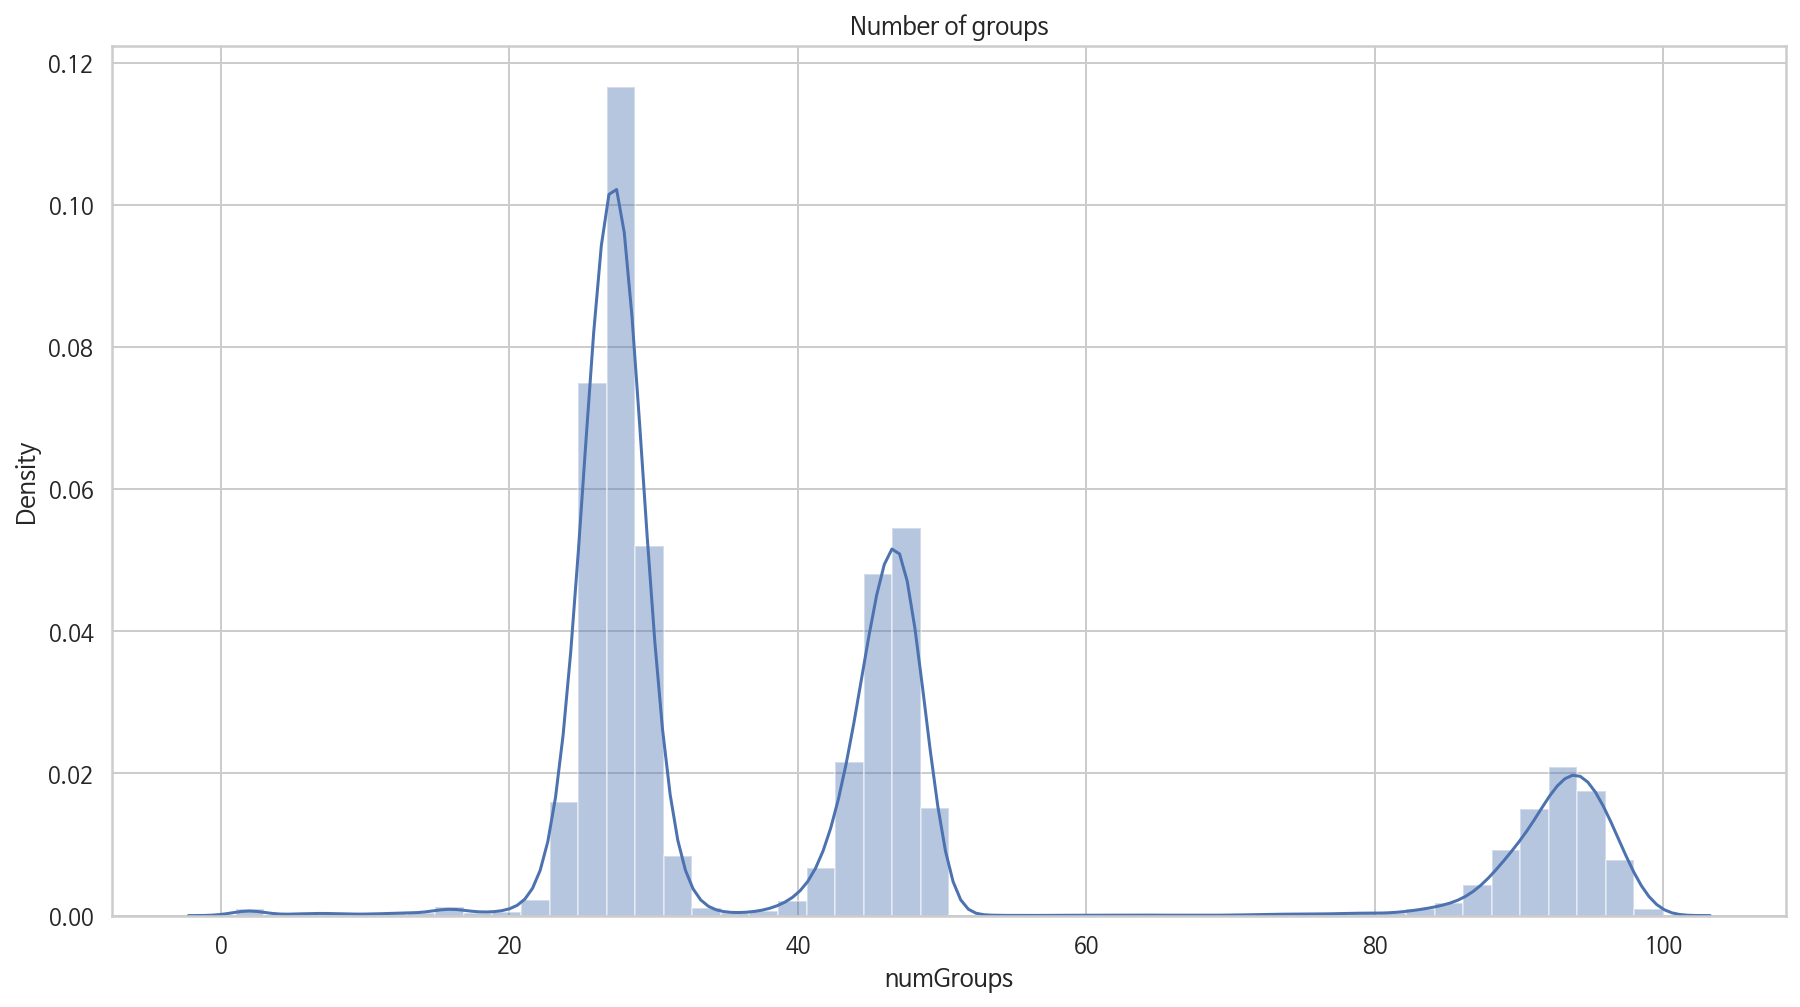

In [22]:
# 게임 내 팀 수
plt.figure(figsize=(15,8))
ax = sns.distplot(df["numGroups"])
ax.set_title("Number of groups")
plt.show()

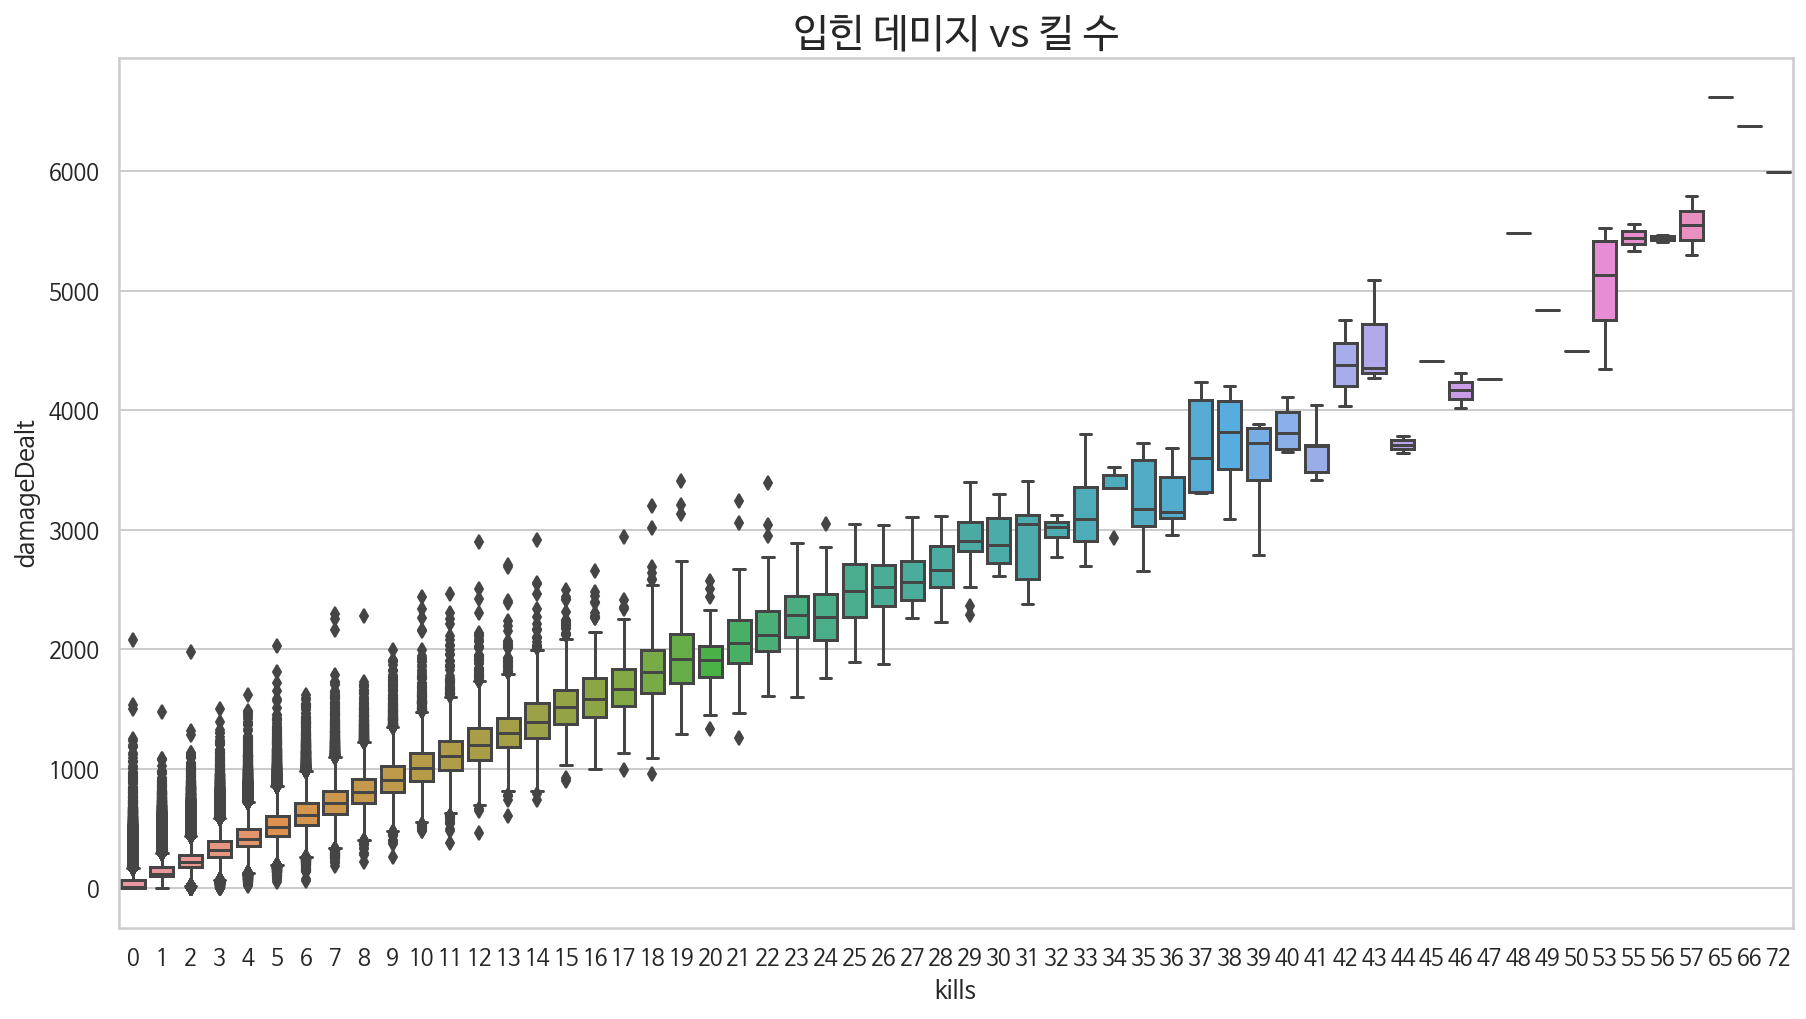

In [23]:
# 킬수와 입힌 데미지에는 상관관계가 존재한다.
# 낮은 쪽에 이상치가 존재하며, 킬수가 증가함에 따라 이상치의 수가 감소하는 모습을 보여준다.
# 최대 킬수는 72kill로, 대부분의 플레이어가 기록하는 점수보다 훨씬 많다.
plt.figure(figsize=(15,8))
ax1 = sns.boxplot(x="kills",y="damageDealt", data = df)
ax1.set_title("입힌 데미지 vs 킬 수", fontsize=20)
plt.show()

In [24]:
# 킬을 많이 한 유저(60킬 이상)
df[df['kills']>60][["Id","assists","damageDealt","headshotKills","kills","longestKill"]]

,Id,assists,damageDealt,headshotKills,kills,longestKill
334400,8102379261545,20,6616.0,13,65,73.90
1248348,80058,5,6375.0,21,66,319.90
3431247,0630898802,7,5990.0,64,72,78.23


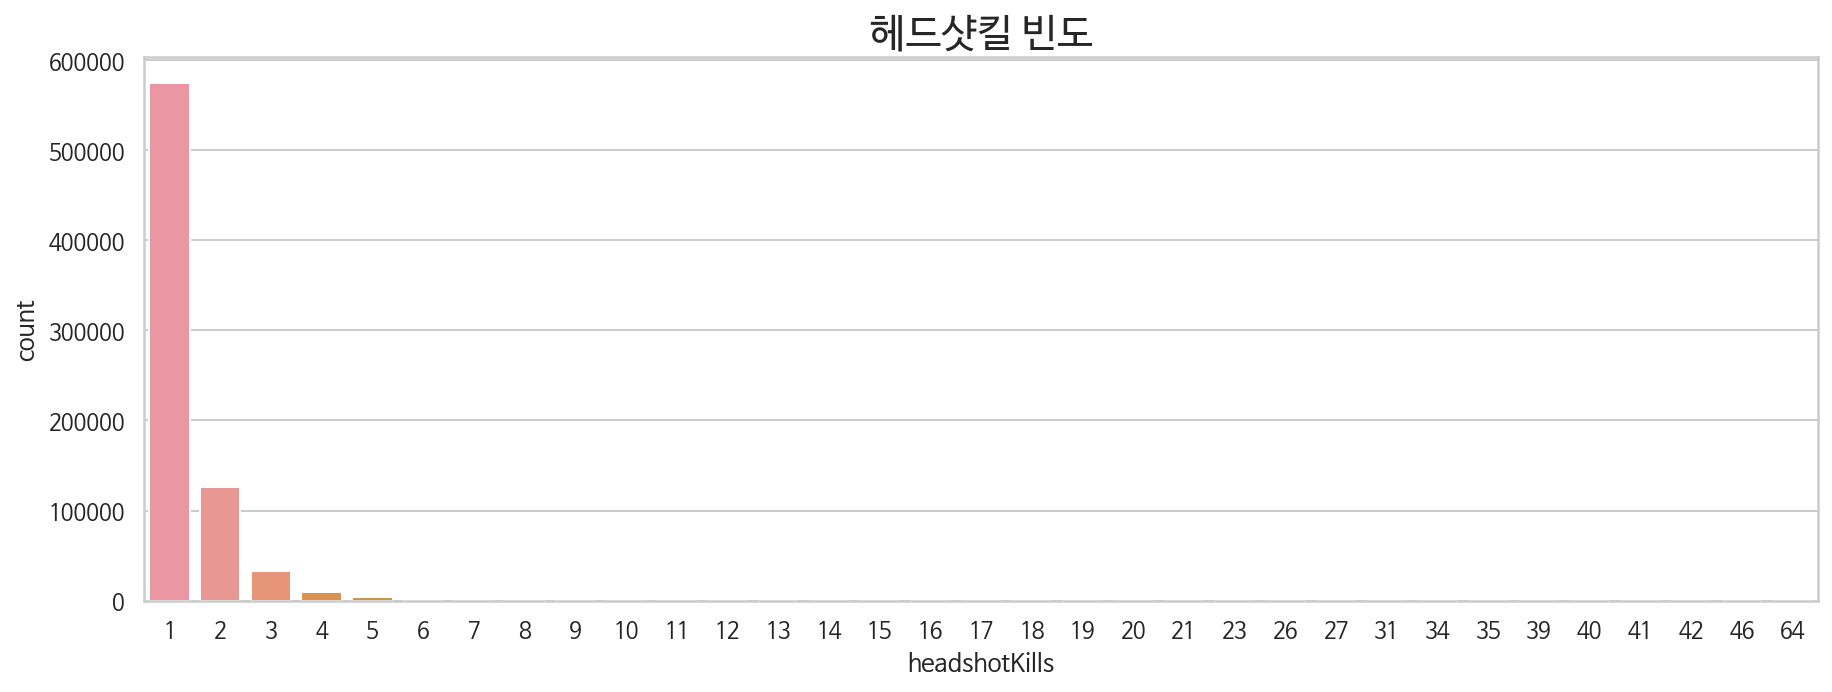

In [25]:
# 경기 중에 가장 높은 점수를 얻을 수 있는 요소인 헤드샷으로 통계 확인
# 헤드샷이 없는 유저는 필터링
headshot = df[df['headshotKills']>0]
plt.figure(figsize=(15,5))
plt.title('헤드샷킬 빈도', fontsize=20)
sns.countplot(headshot['headshotKills'].sort_values())

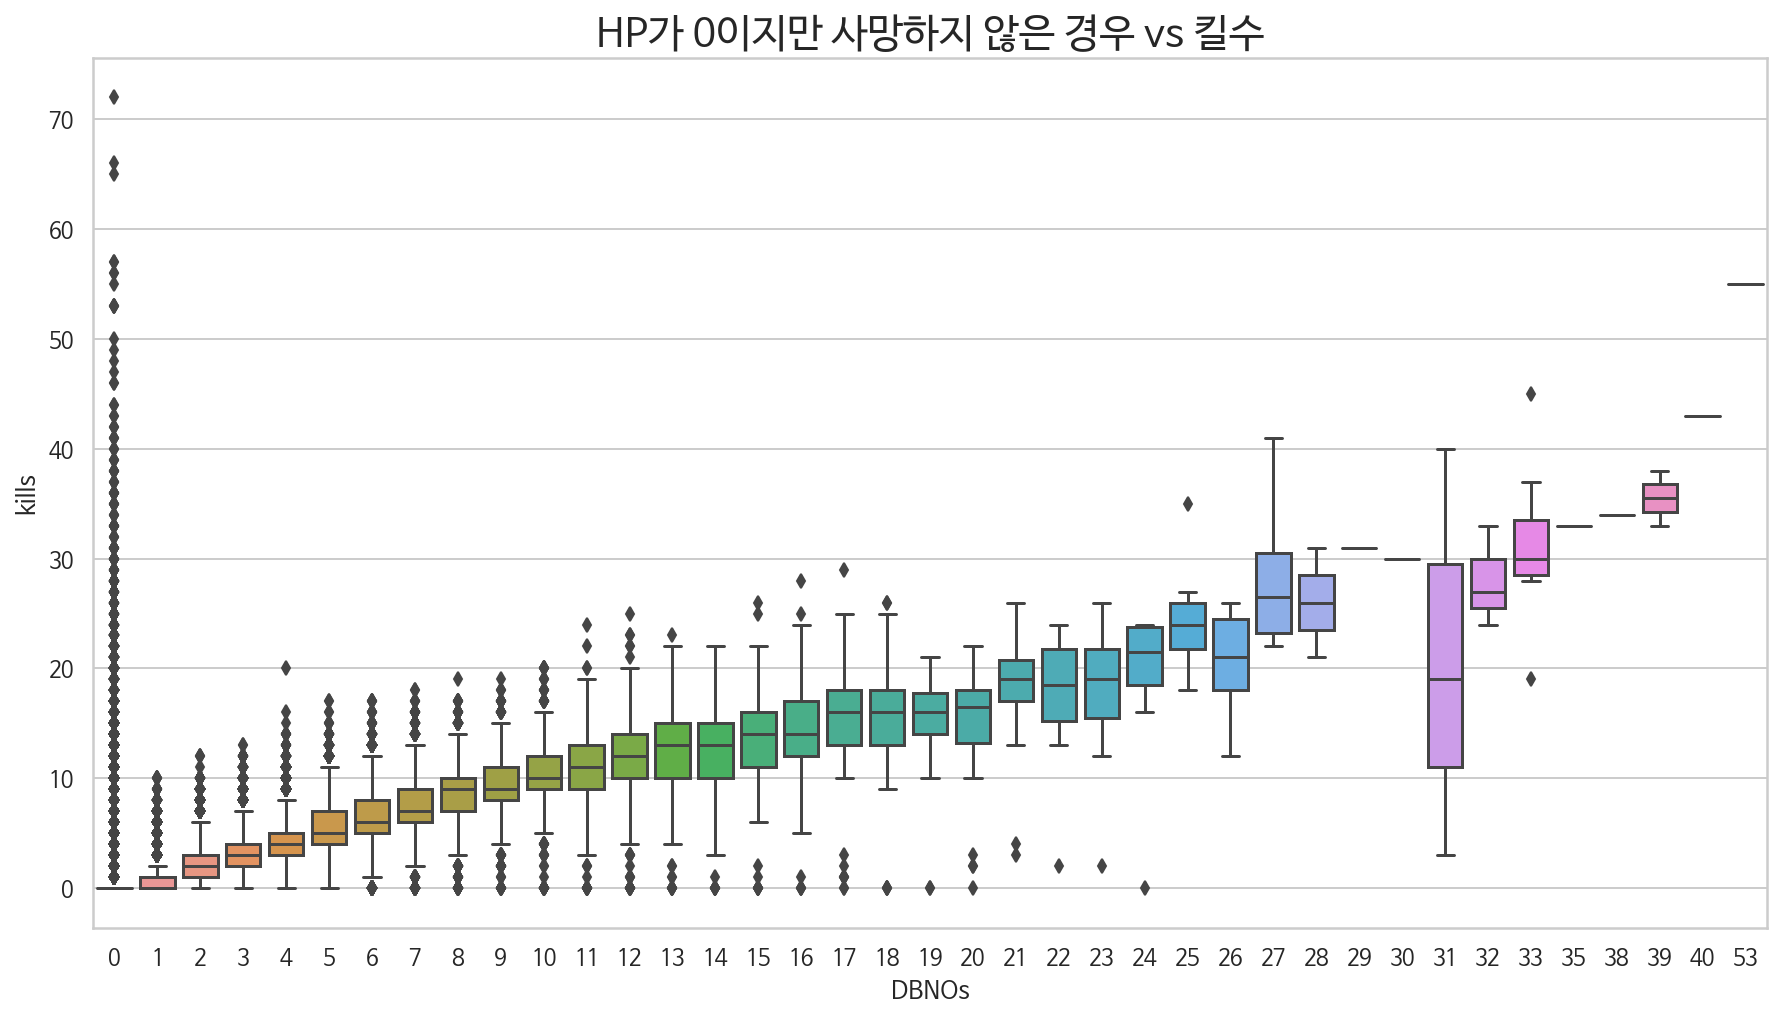

In [26]:
# HP가 0이지만 사망하지 않은 경우(치명상)와 킬수 간에 상관관계가 있는지 확인
plt.figure(figsize=(15,8))
ax2 = sns.boxplot(x="DBNOs",y="kills", data = df)
ax2.set_title("HP가 0이지만 사망하지 않은 경우 vs 킬수", fontsize=20)
plt.show()

# 치명상 상태와 킬수가 상관관계가 있는 것으로 파악된다. 일반적으로 플레이어가 헤드샷으로 죽지 않으려면 치명상 상태에서 끝내야 하는 것과 같이 의미가 있다.
# 치명상 없이 킬을 기록한 유저가 있는데, 이는 헤드샷이나 차량 폭발로 추정된다.

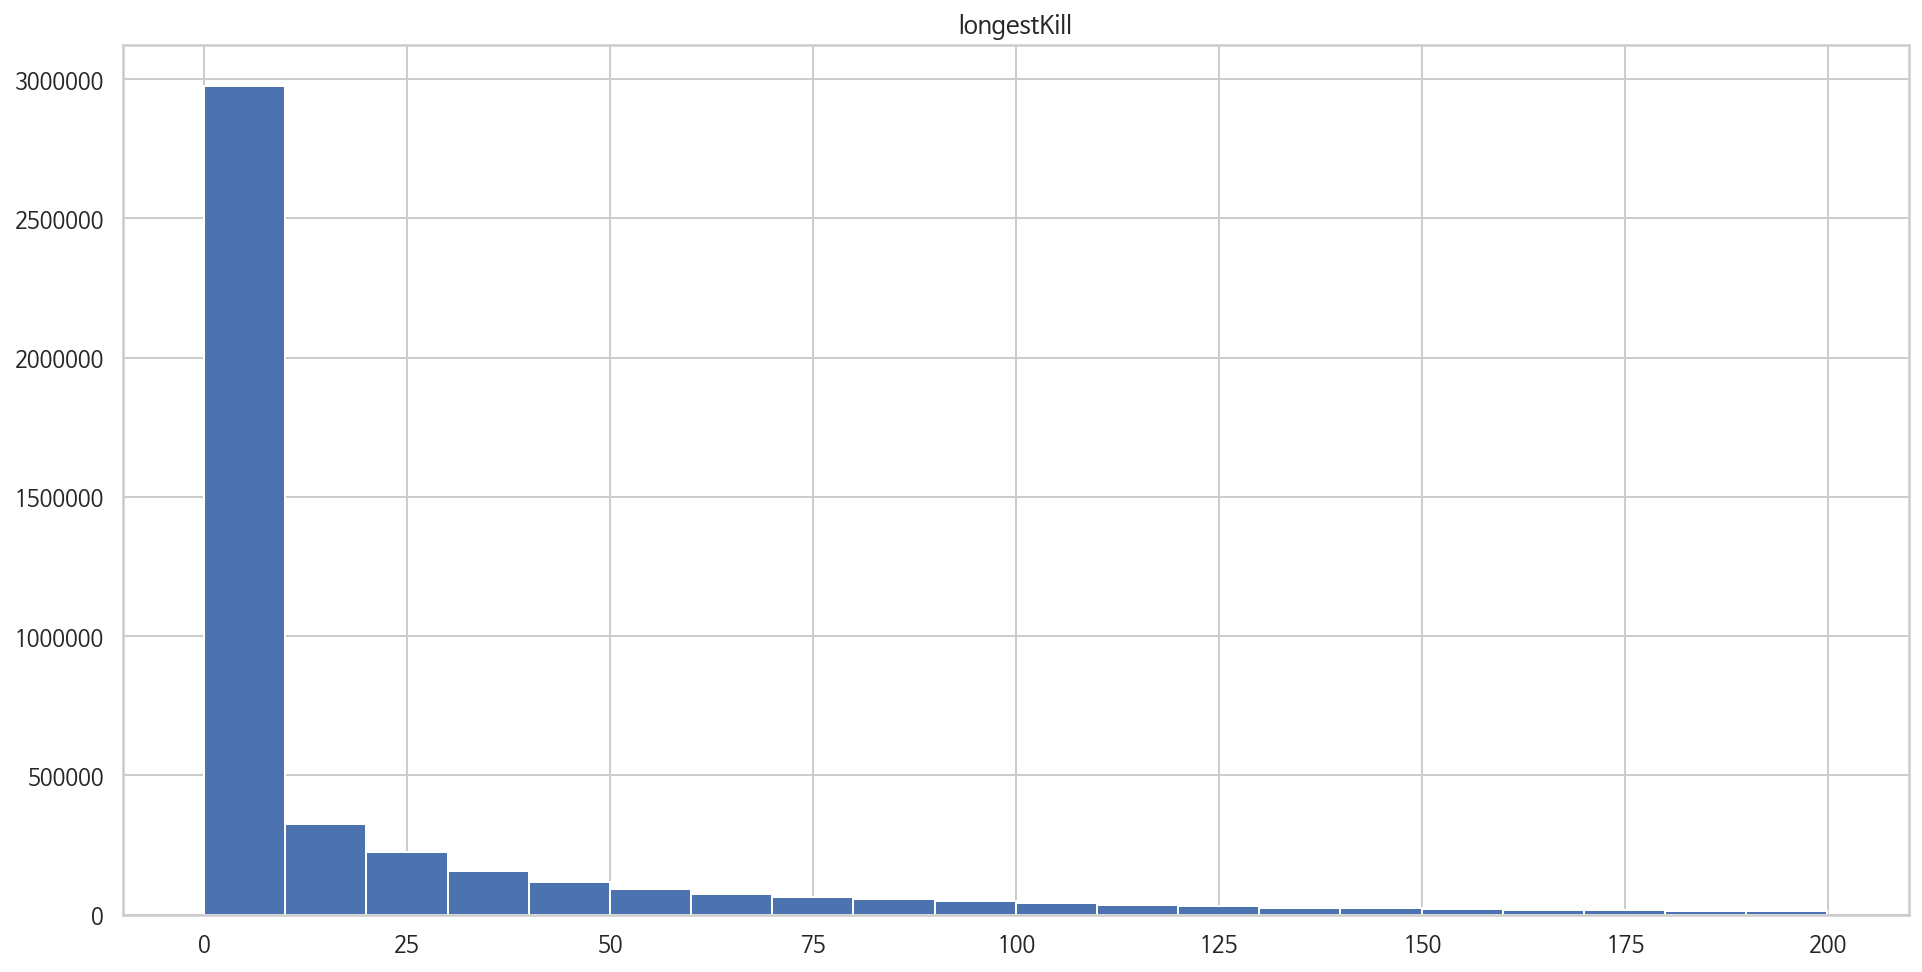

In [27]:
# 킬을 낸 최대 거리
dist = df[df['longestKill']<200]
plt.rcParams['axes.axisbelow'] = True
dist.hist('longestKill', bins=20, figsize = (16,8))
plt.show()

In [28]:
print("플레이어가 달성한 평균 킬 최장 거리는 {:.1f}m 이다. 그중 95% 이하가 {:.1f}m 이하이고, 최대거리는 {:.1f}m 이다." .format(df['longestKill'].mean(),df['longestKill'].quantile(0.95),df['longestKill'].max()))

플레이어가 달성한 평균 킬 최장 거리는 23.0m 이다. 그중 95% 이하가 126.1m 이하이고, 최대거리는 1094.0m 이다.


In [29]:
# 회복류 아이템(구급상자, 에너지 드링크 등) 사용량 데이터 생성

df['healboost'] = df['heals'] + df['boosts']
df[['heals', 'boosts', 'healboost']].tail()

,heals,boosts,healboost
4446961,0,0,0
4446962,0,1,1
4446963,0,0,0
4446964,2,4,6
4446965,1,2,3


In [30]:
# 이상치(outlier) 찾기
# 데이터의 일부분은 이상치를 가지고 있다. 부정행위로 인해 기록된 데이터가 이에 해당될 수 있다.
# 이상치를 제거하여 정제 결과를 개선

display(df[df['killsWithoutMoving'] == True].shape)
df[df['killsWithoutMoving'] == True].head(10)

(1535, 39)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate,healboost
1824,5385142476,0224396,3577504422,0,0,593.00,0,0,3,18,...,58,8.52,842.0600,21.30,842.06,3,0.0,True,0.000000,3
6673,6361077,28119154487,90436217,2,0,346.60,0,0,6,33,...,42,4.74,547.6280,17.38,2834.52,6,0.0,True,0.000000,6
11892,5503988337,3020,66104904,2,0,1750.00,0,4,5,3,...,21,35.80,3132.5000,35.80,1607.42,5,0.0,True,0.200000,5
14631,586904619,566303367,34301553,0,0,157.80,0,0,0,69,...,73,1.27,200.4060,24.13,1014.73,0,0.0,True,0.000000,0
15591,4961963632,05519921,90436217,0,0,100.00,0,1,0,37,...,42,1.58,158.0000,17.38,2834.52,0,0.0,True,1.000000,0
20881,40871437,204671,0600861164,0,0,506.10,4,1,3,7,...,44,9.36,789.5160,9.36,909.48,3,0.0,True,0.166667,3
23298,9508360427,1735100549,8604162,1,0,1124.00,0,4,1,7,...,48,18.24,1708.4800,9.12,836.00,1,0.0,True,0.333333,1
24640,114619,4009954,7338699171,2,0,529.90,0,2,11,12,...,57,10.01,757.7570,21.45,856.57,11,0.0,True,0.285714,11
25659,66264470,3509173,3413418347941,0,1,128.90,0,1,6,53,...,61,2.78,179.1710,11.12,1017.48,7,0.0,True,0.500000,7
30079,869331903,869303653,373285062,0,0,85.56,0,0,0,46,...,53,1.47,125.7732,22.05,1051.05,0,0.0,True,0.000000,0


In [31]:
# 이상치 제거
df.drop(df[df['killsWithoutMoving'] == True].index, inplace=True)

In [32]:
# 가설1 : 로드킬(이동수단을 통한)을 10회 이상 하였을 경우 부정행위로 간주
df[df['roadKills'] > 10]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate,healboost
2733926,344471289,4896123,47974822054,0,0,1246.0,0,0,0,1,...,92,15.12,1345.68,99.36,1572.48,0,1282.302,False,0.000000,0
2767999,34193085975338,750305700,2235403636,0,0,1102.0,0,0,0,1,...,88,12.32,1234.24,98.56,2179.52,0,4934.600,False,0.000000,0
2890740,34389343535,10813158014,7444300070,0,8,2074.0,0,1,11,1,...,38,32.40,3359.88,61.56,3191.40,19,5876.000,False,0.050000,19
3524413,990448172,89717923,859225125,0,3,1866.0,0,5,7,1,...,84,20.88,2164.56,97.44,2233.00,10,7853.000,False,0.277778,10


In [33]:
# 로드킬을 10회이상 한 유저 제거
df.drop(df[df['roadKills'] > 10].index, inplace=True)

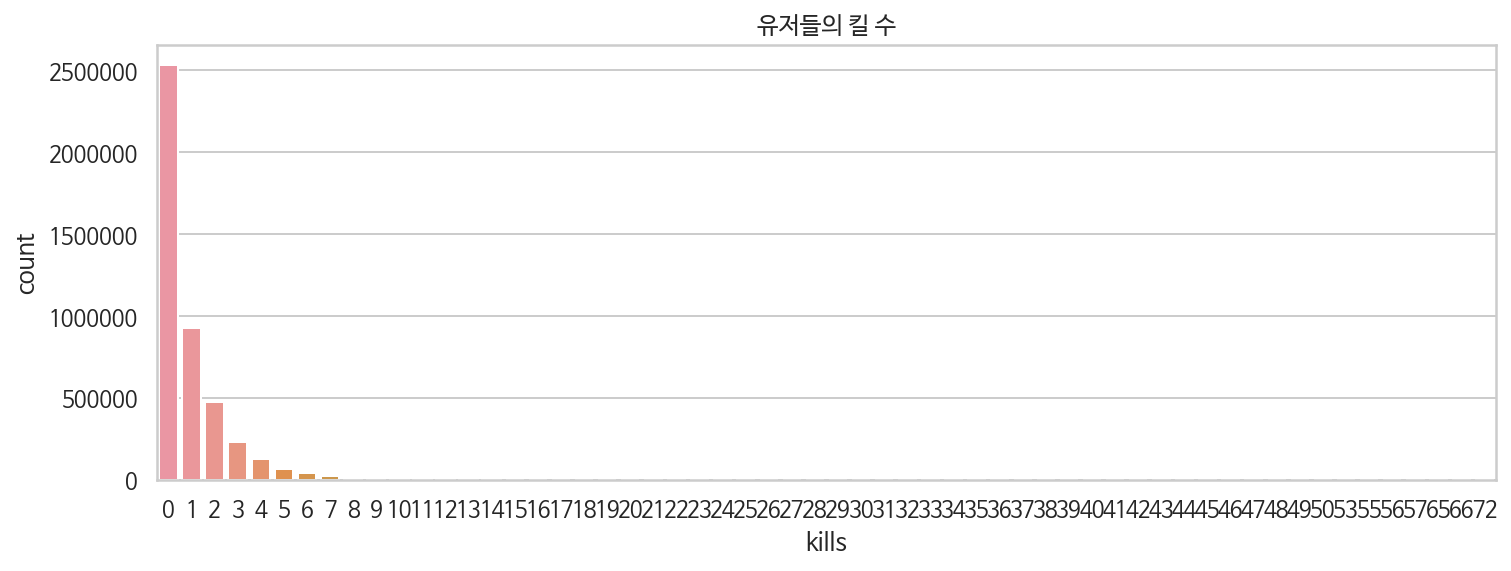

In [34]:
# 유저의 킬 수 시각화
plt.figure(figsize=(12,4))
sns.countplot(data=df, x=df['kills']).set_title('유저들의 킬 수')
plt.show()
# 비정상적인 킬 수(이상치)가 적거나 없는 것으로 보인다.

In [35]:
# 30킬 이상을 달성한 유저
display(df[df['kills'] > 30].shape)
df[df['kills'] > 30].head(10)

(95, 39)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate,healboost
57978,9825321,71358568,3705201015,9,0,3725.0,0,7,0,2,...,16,64.40,6854.00,14.72,3308.32,0,48.82,False,0.200000,0
87793,4576442384931,362775894134,3705201015,8,0,3087.0,0,8,27,3,...,16,57.04,5680.08,14.72,3308.32,27,780.70,False,0.258065,27
156599,7467786,5723782503,9001395,21,0,5479.0,0,12,7,4,...,11,90.72,10355.31,20.79,3398.22,7,23.71,False,0.250000,7
160254,15622257442,1513724,413748292,1,0,4033.0,0,40,0,1,...,62,57.96,5565.54,11.04,1164.72,0,718.30,False,0.952381,0
180189,13556134320,8633861,3944262855,5,0,3171.0,0,6,15,1,...,11,66.15,5993.19,17.01,3394.44,15,71.51,False,0.171429,15
334400,8102379261545,7349371534,9001395,20,0,6616.0,0,13,5,1,...,11,122.85,12504.24,20.79,3398.22,5,1036.00,False,0.200000,5
353128,397463151,410007304,984456859,2,0,3834.0,0,9,5,1,...,13,72.93,7169.58,24.31,3356.65,5,124.20,False,0.230769,5
457829,265237560,99442417121,66498646,3,0,2907.0,0,27,2,1,...,38,53.46,4709.34,8.10,1339.74,2,382.40,False,0.818182,2
488335,31068292245,27527348,303774833,2,0,3055.0,0,9,0,1,...,20,59.40,5499.00,32.40,1605.60,0,35.30,False,0.272727,0
662650,42487449,966226,87280644,9,0,3454.0,38,9,4,1,...,54,49.64,5042.84,20.44,1749.08,4,111.10,False,0.264706,4


In [36]:
# 가설2 : 보통 한 경기에서 30킬 이상 나오는 경우가 거의 없어서 30킬 이상을 달성했다면 부정행위로 간주한다.
# 30킬 이상 달성한 유저 데이터 삭제
df.drop(df[df['kills'] > 30].index, inplace=True)

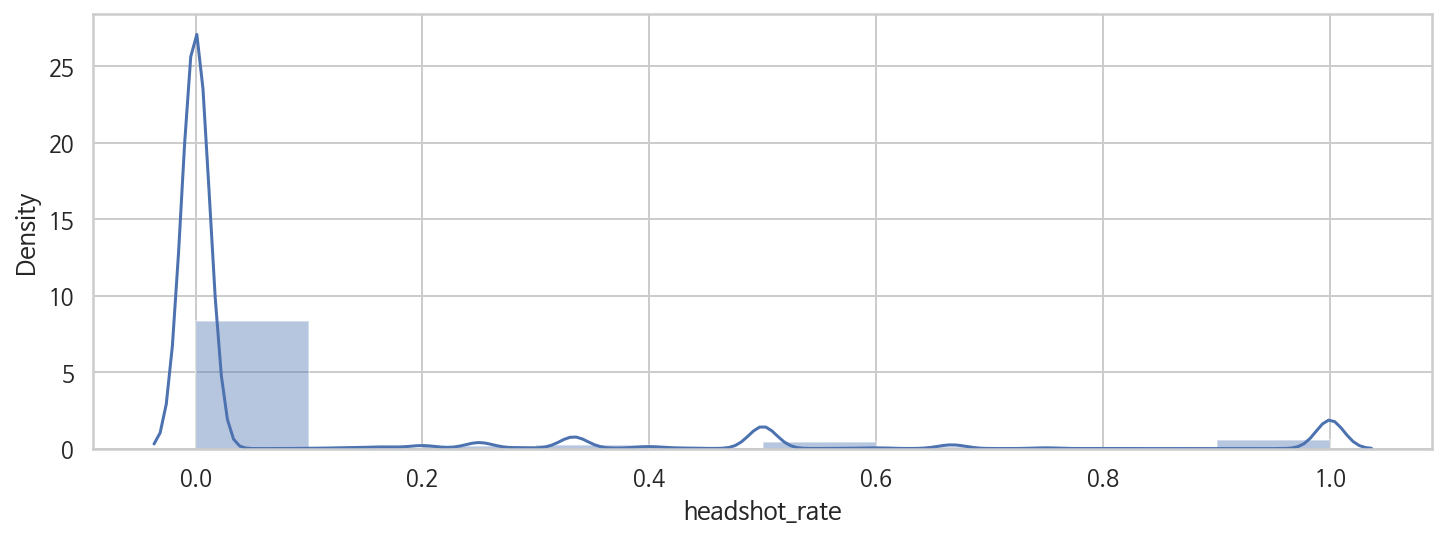

In [37]:
# 가설3 : 한 경기에서 헤드샷 비율이 100%인 유저
plt.figure(figsize=(12,4))
sns.distplot(df['headshot_rate'], bins=10)
plt.show()

In [38]:
# 10킬 이상을 달성하고, 헤드샷 명중률이 100%인 유저
display(df[(df['headshot_rate'] == 1) & (df['kills'] > 9)].shape)
df[(df['headshot_rate'] == 1) & (df['kills'] > 9)].head(10)

(24, 39)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate,healboost
281570,97168570927,050214,0168733397,2,3,1212.0,8,10,0,1,...,93,10.70,1296.84,28.89,1522.61,3,2939.0,False,1.0,3
346124,044184275,126887,628107441084,3,5,1620.0,13,11,3,1,...,96,11.44,1684.80,28.08,1796.08,8,8142.0,False,1.0,8
871244,6682554883,58223,66581034,0,4,1365.0,9,13,0,1,...,98,13.26,1392.30,27.54,1280.10,4,2105.0,False,1.0,4
908815,5668218705,9056478712,341552553583,2,5,1535.0,10,10,3,1,...,95,10.50,1611.75,29.40,1929.90,8,7948.0,False,1.0,8
963463,1628840,905842215,299278,2,6,1355.0,12,10,2,1,...,96,10.40,1409.20,28.08,1473.68,8,3476.0,False,1.0,8
1079403,124599596,420998463,523668,0,5,1218.0,8,11,3,1,...,95,11.55,1278.90,29.40,1912.05,8,8178.0,False,1.0,8
1167959,48045561,478921895,77733447,0,4,1065.0,6,10,1,1,...,97,10.30,1096.95,27.81,1283.38,5,2858.9,False,1.0,5
1348164,47464104,23630,11449982357,1,5,1319.0,11,12,1,1,...,93,12.84,1411.33,29.96,1851.10,6,5963.0,False,1.0,6
1380385,2026551195,2668615974,49670029544,1,4,1150.0,4,11,1,1,...,88,12.32,1288.00,51.52,1397.76,5,3108.0,False,1.0,5
1483199,94837344,5867814191,6949534789,0,10,1478.0,8,13,2,1,...,96,13.52,1537.12,50.96,1434.16,12,2479.8,False,1.0,12


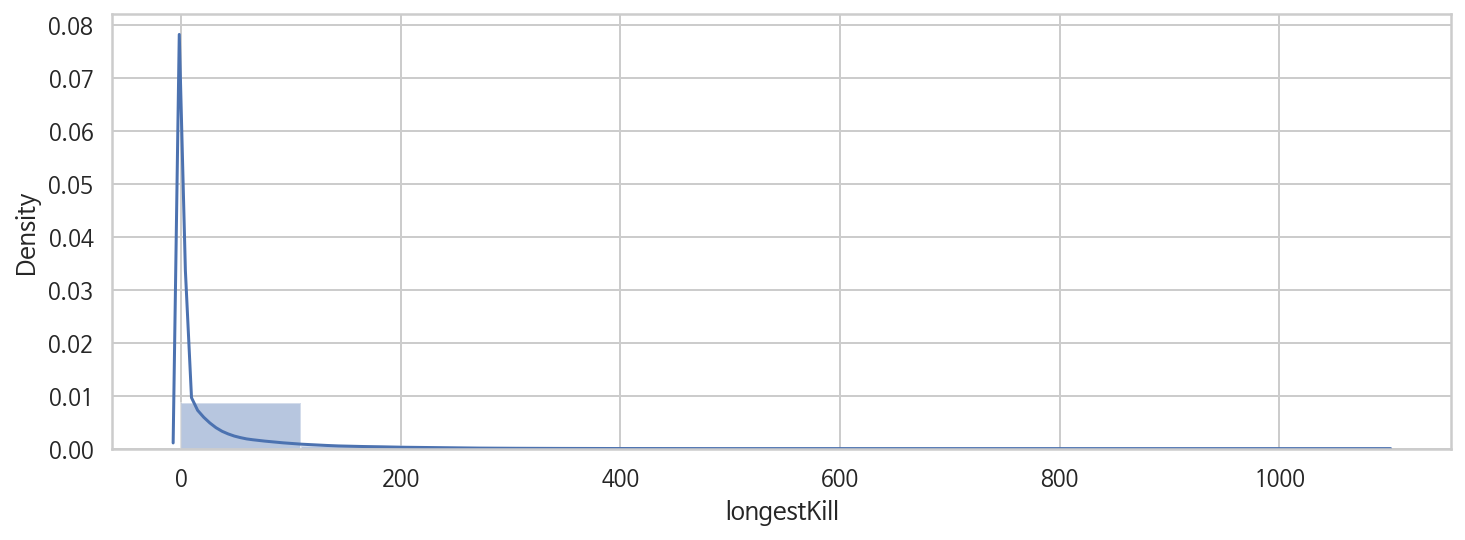

In [39]:
# 10킬을 하는 동안 헤드샷 명중률이 100%일 가능성은 현실적으로 존재하므로 모두 부정행위로 간주하기는 어려울 수 있다.
# 그러므로 이 데이터는 삭제하지 않는다.
# 가설 3 : 대부분의 킬은 100m 이내의 근접킬이 이루어지지만, 1km가 떨어진 거리에서 킬을 하는 일부 이상치가 있다.
# 1km가 떨어져있는 경우 저격총을 들어도 킬내기가 쉽지 않다. 이러한 경우는 부정행위를 했다고 볼 수 있다.
plt.figure(figsize=(12,4))
sns.distplot(df['longestKill'], bins=10)
plt.show()

In [40]:
# 1km 거리에서 킬을 낸 유저의 수
display(df[df['longestKill'] >= 1000].shape)
df[df['longestKill'] >= 1000].head(10)

(20, 39)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate,healboost
202281,8827785,3452042,43466367,0,3,783.9,5,1,1,5,...,88,4.48,877.968,30.24,2087.68,4,3775.20,False,0.250000,4
240005,41250699807,9874275,634758603,5,0,1284.0,8,5,7,18,...,29,18.81,2195.640,23.94,2236.68,7,48.87,False,0.454545,7
324313,3901523,3044431,47865584,2,0,1028.0,0,0,0,9,...,51,14.90,1531.720,19.37,1040.02,0,2981.00,False,0.000000,0
656553,9948058562163,884911126,0104664494,6,0,1410.0,17,5,0,3,...,41,25.44,2241.900,9.54,1734.69,0,29.21,False,0.312500,0
803632,47674357,94698690918933,91038758,0,0,196.8,0,0,0,51,...,61,1.39,273.552,11.12,654.69,0,3159.00,False,0.000000,0
895411,1560968,512248313,508116,4,0,1012.0,11,5,0,5,...,86,11.40,1153.680,13.68,1163.94,0,569.50,False,0.500000,0
1172437,30393146,879539086,989625833,2,1,329.3,0,0,2,45,...,58,4.26,467.606,11.36,825.02,3,832.50,False,0.000000,3
1209416,52865911,7183423551,93865875888,0,6,1640.0,0,7,0,1,...,52,22.20,2427.200,76.96,1827.80,6,2848.00,False,0.466667,6
1642712,91966848082,04276579,172262,3,2,2103.0,0,4,11,11,...,28,39.56,3617.160,25.80,3092.56,13,235.30,False,0.173913,13
2015559,50192,28119154487,90436217,3,3,1302.0,0,6,5,15,...,42,17.38,2057.160,17.38,2834.52,8,133.20,False,0.545455,8


In [41]:
# 부정행위로 간주한 1km 킬 데이터 삭제
df.drop(df[df['longestKill'] >= 1000].index, inplace=True)

In [42]:
# 필드 이동중에 발생한 부정행위를 찾아내기 위해 이동중 발생한 이상치를 찾기
# 자기장의 영향을 받기 때문에 엄청나게 먼 거리를 걷거나 뛰어서 이동하기는 쉽지 않다.
df[['walkDistance', 'rideDistance', 'swimDistance', 'totalDistance']].describe()

,walkDistance,rideDistance,swimDistance,totalDistance
count,4.445311e+06,4.445311e+06,4.445311e+06,4.445311e+06
mean,1.154628e+03,6.063272e+02,4.510977e+00,1.765466e+03
std,1.183514e+03,1.498567e+03,3.050773e+01,2.183257e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.554000e+02,0.000000e+00,0.000000e+00,1.584000e+02
50%,6.864000e+02,0.000000e+00,0.000000e+00,7.893000e+02
75%,1.977000e+03,2.606500e-01,0.000000e+00,2.729000e+03
max,2.578000e+04,4.071000e+04,3.823000e+03,4.127010e+04


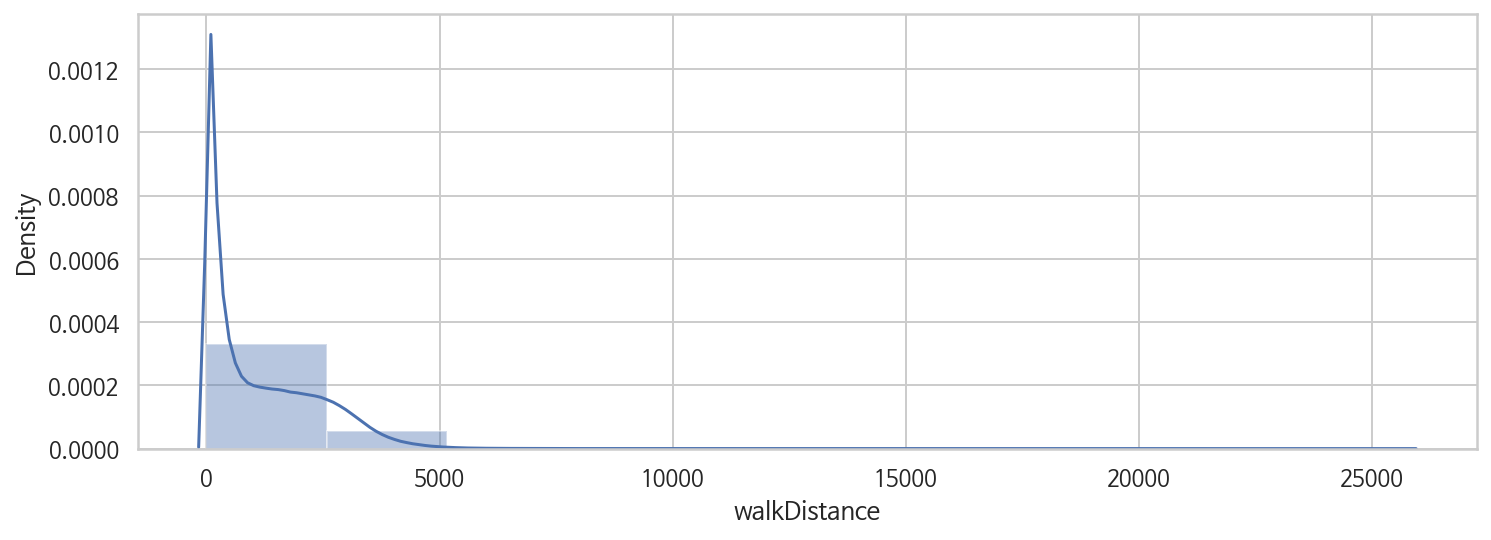

In [43]:
# 비정상적인 이동거리가 일부 존재하는 것으로 보인다.
plt.figure(figsize=(12,4))
sns.distplot(df['walkDistance'], bins=10)
plt.show()

In [44]:
# 이동거리 이상치 찾기
display(df[df['walkDistance'] >= 10000].shape)
df[df['walkDistance'] >= 10000].head(10)

(219, 39)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,totalDistance,killsWithoutMoving,headshot_rate,healboost
23026,8656238183,23638677,080461090,0,1,0.00,0,0,0,44,...,99,0.00,0.0000,99.99,1925.06,1,13540.3032,False,0.0,1
34344,5591957393,671737051247,1593716505,0,3,23.22,0,0,1,34,...,65,0.00,31.3470,27.00,2668.95,4,10070.9073,False,0.0,4
49312,58268548704,3381121217,05369,0,4,117.20,1,0,1,24,...,94,1.06,124.2320,49.82,2323.52,5,12446.7588,False,0.0,5
68590,80904463,9635539379,92668172147,0,1,32.34,0,0,1,46,...,96,0.00,33.6336,50.96,1909.44,2,12483.6200,False,0.0,2
94400,4410161,717933668,923578834,1,1,73.08,0,0,3,27,...,73,0.00,92.8116,92.71,2293.62,4,11490.6300,False,0.0,4
125103,50969,50466757950,306974541,0,4,37.73,0,0,7,47,...,95,0.00,39.6165,99.75,2054.85,11,12828.7978,False,0.0,11
136421,9556009961,300822901,866901725135,0,1,0.00,0,0,1,46,...,94,0.00,0.0000,49.82,2091.38,2,12223.8100,False,0.0,2
136476,075055988,3040770,655211569,0,3,0.00,0,0,0,41,...,91,0.00,0.0000,99.19,2028.49,3,14918.2000,False,0.0,3
154080,787123381,294928402,721105408,0,3,0.00,0,0,13,46,...,94,0.00,0.0000,99.64,2038.38,16,12636.7000,False,0.0,16
154128,324716787,390951118,8261014033,0,4,52.16,0,0,7,25,...,95,1.05,54.7680,50.40,1927.80,11,10889.8614,False,0.0,11


In [45]:
# 이동거리 이상치 제거(가설4 : 10km 이상 이동한 경우 부정행위로 간주)
df.drop(df[df['walkDistance'] >= 10000].index, inplace=True)

In [ ]:
# 이동수단을 탑승한 채로 이동한 거리 이상치 찾기
# 가설5 : 이동수단을 타고 20 km 이상 이동한 경우 부정행위로 간주
plt.figure(figsize=(12,4))
sns.distplot(df['rideDistance'], bins=10)
plt.show()

In [ ]:
# 이동수단을 탑승한 채로 20km 이상 이동한 유저
display(df[df['rideDistance'] >= 20000].shape)
df[df['rideDistance'] >= 20000].head(10)

In [ ]:
# 이동수단을 탑승한 채로 20km 이상 이동한 유저데이터 삭제
df.drop(df[df['rideDistance'] >= 20000].index, inplace=True)

In [ ]:
# 수영으로 이동한 거리 이상치 찾기
plt.figure(figsize=(12,4))
sns.distplot(df['swimDistance'], bins=10)
plt.show()

In [ ]:
# 가설6 : 수영으로 2km 이상을 이동했다면 비정상적인 플레이로 간주하고 이상치 찾기
df[df['swimDistance'] >= 2000]

In [ ]:
# 수영으로 2km 이상 이동한 유저 데이터 제거
df.drop(df[df['swimDistance'] >= 2000].index, inplace=True)

In [ ]:
# 보급품 획득에 이상이 있는 데이터 찾기
# 대부분의 유저들은 0개에서 10개 사이의 무기를 획득하지만 80개 이상을 획득한 경우 부정행위로 판단할 수 있다.
plt.figure(figsize=(12,4))
sns.distplot(df['weaponsAcquired'], bins=100)
plt.show()

In [ ]:
# 80개 이상의 무기를 획득한 유저
display(df[df['weaponsAcquired'] >= 80].shape)
df[df['weaponsAcquired'] >= 80].head()

In [ ]:
# 80개 이상의 무기를 비정상적으로 획득한 유저 데이터 삭제
df.drop(df[df['weaponsAcquired'] >= 80].index, inplace=True)

In [ ]:
# 소모품 사용 이상치 찾기
# 비정상적으로 많은 소모품을 사용한 유저를 찾기

# 소모품 사용 빈도
plt.figure(figsize=(12,4))
sns.distplot(df['heals'], bins=10)
plt.show()

In [ ]:
# 40개 이상 소모품을 사용한 유저
display(df[df['heals'] >= 40].shape)
df[df['heals'] >= 40].head(10)

In [ ]:
# 40개 이상 비정상적으로 소모품을 사용한 유저 데이터 삭제
df.drop(df[df['heals'] >= 40].index, inplace=True)

# 이상치 제거로 인하여 약 2000명의 유저 데이터가 삭제됨.

In [ ]:
df.shape

### 2. 범주형 변수

랜덤 포레스트 모델에서 사용하기 위해 'matchType'을 OneHotEncoding.

In [ ]:
train = df

In [ ]:
# OneHotEncoding 'matchType'
train = pd.get_dummies(train, columns=['matchType'])

# 원 핫 인코딩 보기
matchType_encoding = train.filter(regex='matchType')
matchType_encoding.head()

In [ ]:
# 그룹ID와 매치ID가 다수 존재하기 때문에 OneHotEncoding 은 효율이 낮을 것으로 판단
# 그룹ID와 매치ID를 범주형(Categorical variables)으로 변환하여 랜덤 포레스트 알고리즘에서 그룹과 일치항목간의 상관관계에서 이점을 얻을 수 있다.
train['groupId'] = train['groupId'].astype('category')
train['matchId'] = train['matchId'].astype('category')

In [ ]:
train['groupId_cat'] = train['groupId'].cat.codes
train['matchId_cat'] = train['matchId'].cat.codes

In [ ]:
# 기존 컬럼 제거
train.drop(columns=['groupId', 'matchId'], inplace=True)

In [ ]:
train[['groupId_cat', 'matchId_cat']].head()

### 3. Machine Learning
훈련 데이터셋에서 50만개의 샘플을 가져온다.

In [ ]:
# 라이브러리 호출

import eli5
import shap
import xgboost
import warnings

from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_interact, pdp_interact_plot, pdp_plot
from scipy.stats import randint, uniform
from ipywidgets import interact, fixed
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer

warnings.filterwarnings(action='ignore')

In [ ]:
# 샘플링
sample = 500000
df_sample = train.sample(sample)

In [ ]:
# 샘플을 훈련 데이터와 타겟 데이터로 분리
df = df_sample.drop(columns = ['winPlacePerc']) # 타겟을 제외한 모든 열
y = df_sample['winPlacePerc'] # 타겟 변수만

In [ ]:
# 훈련 데이터와 검증 데이터로 나누는 함수 정의
def split_vals(a, b : int): 
   return a[:b].copy(), a[b:].copy()

val_perc = 0.12 # 유효성 검사에 사용할 percent
n_val = int(val_perc * sample) 
n_train = len(df)- n_val

# 훈련데이터와 검증데이터로 분할
raw_train, raw_val = split_vals(df_sample, n_train)
x_train, x_val = split_vals(df, n_train)
y_train, y_val = split_vals(y, n_train)

# 샘플 사이즈 확인
print('train data shape: ', x_train.shape, 
      'target data shape: ', y_train.shape, 
      'validation data shape: ', x_val.shape)

In [ ]:
# MAE(Mean absolute error) 값 구하기
def mae_score(m : RandomForestRegressor):
    res = ['mae train: ', mean_absolute_error(m.predict(x_train), y_train), 
           'mae val: ', mean_absolute_error(m.predict(x_val), y_val)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [ ]:
# 첫 번째 Random Forest 모델
model = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='sqrt', n_jobs=-1)
model.fit(x_train, y_train)
mae_score(model)

In [ ]:
# 기본 Random Forest 모델에 따라 예측 가능한 컬럼
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

feature_importance = rf_feat_importance(model, df); feature_importance[:10]

In [ ]:
# 20개의 중요한 데이터에 대한 그래프 그리기
plot1 = feature_importance[:20].plot('cols', 'imp', figsize=(15,8), legend=False, kind = 'barh')
plot1

In [ ]:
# 필요한 feature만 유지
keep = feature_importance[feature_importance.imp>0.005].cols
print('need features: ', len(keep))
keep

In [ ]:
# 위에서 유지한 feature를 DataFrame 으로 만들기
df_keep = df[keep].copy()
x_train, x_val = split_vals(df_keep, n_train)

In [ ]:
# 두 번째 랜덤포레스트 모델
# 상위 feature 만 사용하여 Random Forest 모델 생성
model2 = RandomForestRegressor(n_estimators=80, min_samples_leaf=3, max_features='sqrt',
                          n_jobs=-1)
model2.fit(x_train, y_train)
mae_score(model2)

In [ ]:
# 위에서 생성한 모델에 대한 그래프 그리기
feature_importance_keep = rf_feat_importance(model2, df_keep)
plot2 = feature_importance_keep.plot('cols', 'imp', figsize=(14,6), legend=False, kind = 'barh')
plot2

In [ ]:
# 상관관계 분석
# 상관관계가 높은 feature 를 보기 위해 dendrogram 사용

import scipy
from scipy.stats import randint, norm
from scipy.cluster import hierarchy as hc # 계층적 클러스터링 라이브러리

# Clustering
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(14,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.plot()

In [ ]:
# 상관관계를 Heatmap 으로 나타내기
corr = df_keep.corr()
f, ax = plt.subplots(figsize=(11, 9))
heatmap = sns.heatmap(corr)

In [ ]:
# Kill 의 예측 quality

from plotnine import ggplot, aes, stat_smooth # 격자형 그래프 라이브러리

def sample_data(df,n):
  idxs = sorted(np.random.permutation(len(df))[:n])
  return df.iloc[idxs].copy()

x1 = sample_data(train, 100000)
ggplot(x1, aes('kills','winPlacePerc'))+stat_smooth(se=True, color='red', method='mavg')

In [ ]:
# walkDistance(걷거나 뛰어서 이동한 거리)의 예측 quality
x1 = sample_data(train, 100000)
ggplot(x1, aes('walkDistance','winPlacePerc'))+stat_smooth(se=True, colour='red', method='mavg')

In [ ]:
# 최종 랜덤포레스트 모델

val_perc_final = 0.12 # 유효성 검사
n_val_final = int(val_perc_final * len(train)) 
n_train_final = len(train)-n_val_final
df_final = train.drop(columns = ['winPlacePerc']) # 타겟을 제외한 모든 열
target = train['winPlacePerc'] # 타겟 변수
df_final = df_final[keep] # 관련 변수만 유지
x_train, x_val = split_vals(df_final, n_train_final)
y_train, y_val = split_vals(target, n_train_final)

In [ ]:
# 학습
final_model = RandomForestRegressor(n_estimators=70, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1)
final_model.fit(x_train, y_train)
mae_score(final_model)